In [23]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from src.data.cleaning import clean_sensor_data
from src.features.target import add_minutes_to_dry

# --- Indstillinger ---
plt.rcParams["figure.figsize"] = (12, 6)
timestamp_str = datetime.now().strftime("%Y%m%d-%H%M%S")
output_dir = f"dataanalysis/diagrams_{timestamp_str}"
os.makedirs(output_dir, exist_ok=True)
print(f"Diagrammer gemmes i: {output_dir}")


# --- Hent data fra API ---
def fetch_api_data(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        data = response.json()
        if isinstance(data, list):
            df = pd.DataFrame(data)
        elif isinstance(data, dict) and "response" in data and "list" in data["response"]:
            # Nested structure
            df = pd.DataFrame([item["SampleDTO"] for item in data["response"]["list"]])
        else:
            raise ValueError("Uventet struktur fra API.")

        df["timestamp"] = pd.to_datetime(df["timestamp"])
        return df
    else:
        raise ConnectionError(f"API-kald fejlede med status {response.status_code}")


df_raw = fetch_api_data("https://mal-api.whitebush-734a9017.northeurope.azurecontainerapps.io/sensor/data")



Diagrammer gemmes i: dataanalysis/diagrams_20250519-183712


Antal samples: 940
Minimum soil_humidity: 22


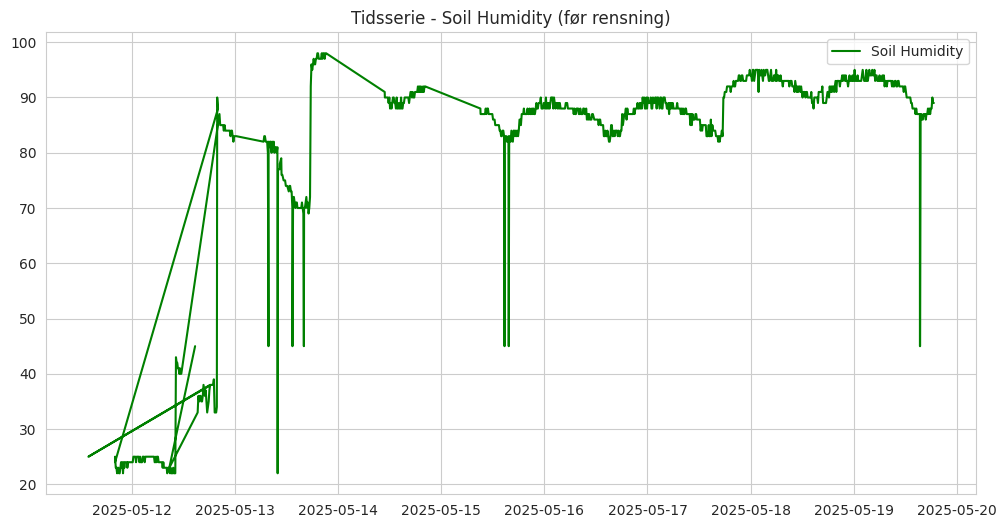

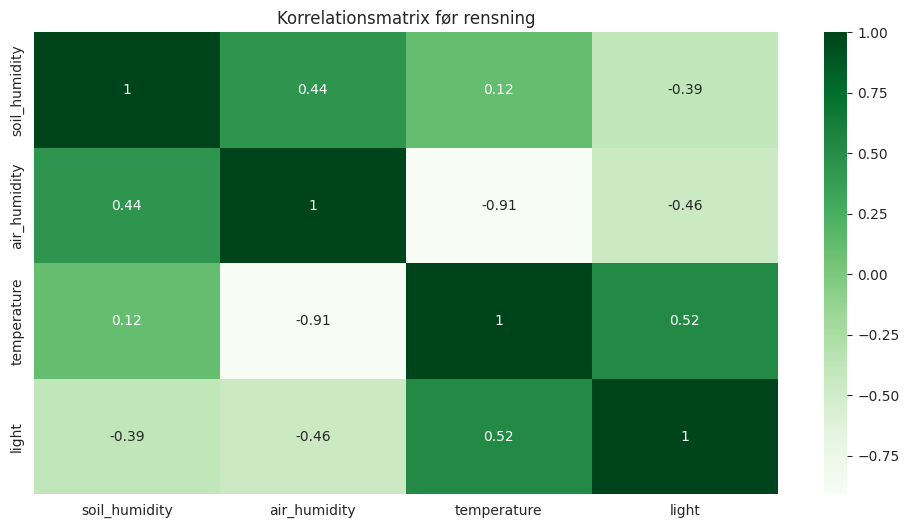

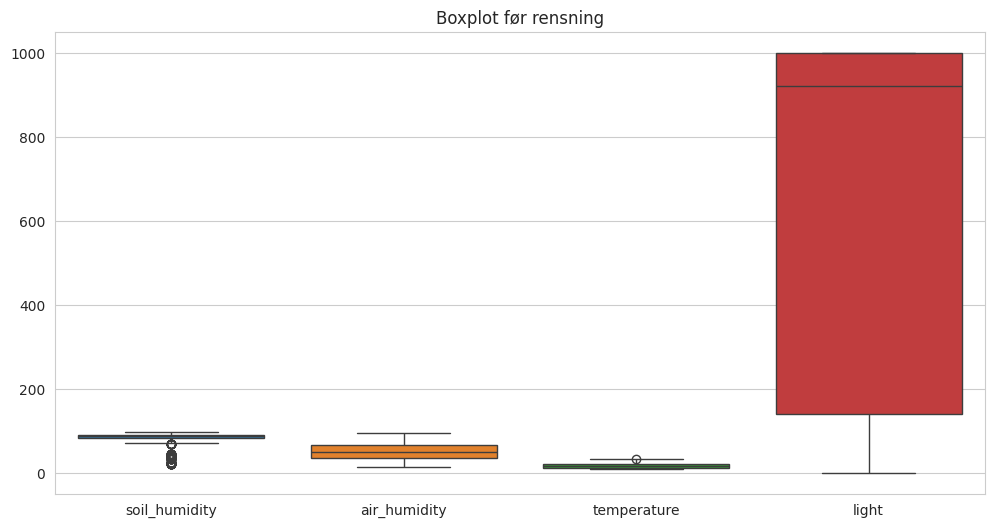

In [24]:
# Renaming of features
rename_map = {
    "soilhumidity": "soil_humidity",
    "airhumidity": "air_humidity",
    "airtemperature": "temperature",
    "light_value": "light",
    "air_temperature": "temperature",
}

df_raw.rename(columns={col: rename_map.get(col.lower(), col) for col in df_raw.columns}, inplace=True)

print(f"Antal samples: {len(df_raw)}")
soilhumidity_threshold = df_raw['soil_humidity'].min()
print(f"Minimum soil_humidity: {soilhumidity_threshold}")

# --- Visualisering: Før rensning ---
plt.plot(df_raw["timestamp"], df_raw["soil_humidity"], label="Soil Humidity", color="green")
plt.title("Tidsserie - Soil Humidity (før rensning)")
plt.legend()
plt.savefig(f"{output_dir}/soil_humidity_timeseries_before_cleaning.png")
plt.show()

sns.heatmap(df_raw[["soil_humidity", "air_humidity", "temperature", "light"]].corr(), annot=True, cmap='Greens')
plt.title("Korrelationsmatrix før rensning")
plt.savefig(f"{output_dir}/correlation_matrix_before_cleaning.png")
plt.show()

sns.boxplot(data=df_raw[["soil_humidity", "air_humidity", "temperature", "light"]])
plt.title("Boxplot før rensning")
plt.savefig(f"{output_dir}/boxplot_before_cleaning.png")
plt.show()


In [25]:
# --- Rensning ---
df_clean = clean_sensor_data(df_raw.copy(), expected_interval_minutes=10, gap_drop_threshold=60)
print(f"Antal samples efter cleaning: {len(df_clean)}")
soilhumidity_threshold = df_clean['soil_humidity'].min() + 2
print(f"Minimum soil_humidity: {soilhumidity_threshold}")

# --- Target-beregning ---
df_clean = add_minutes_to_dry(df_clean, soilhumidity_threshold)
df_clean.dropna(subset=["minutes_to_dry"], inplace=True)
print(f"Antal samples efter target lavet: {len(df_clean)}")

# --- Feature engineering ---
df_clean["hour_sin"] = np.sin(df_clean["timestamp"].dt.hour / 24 * 2 * np.pi)
df_clean["hour_cos"] = np.cos(df_clean["timestamp"].dt.hour / 24 * 2 * np.pi)

Antal samples efter cleaning: 554
Minimum soil_humidity: 84
Antal samples efter target lavet: 293


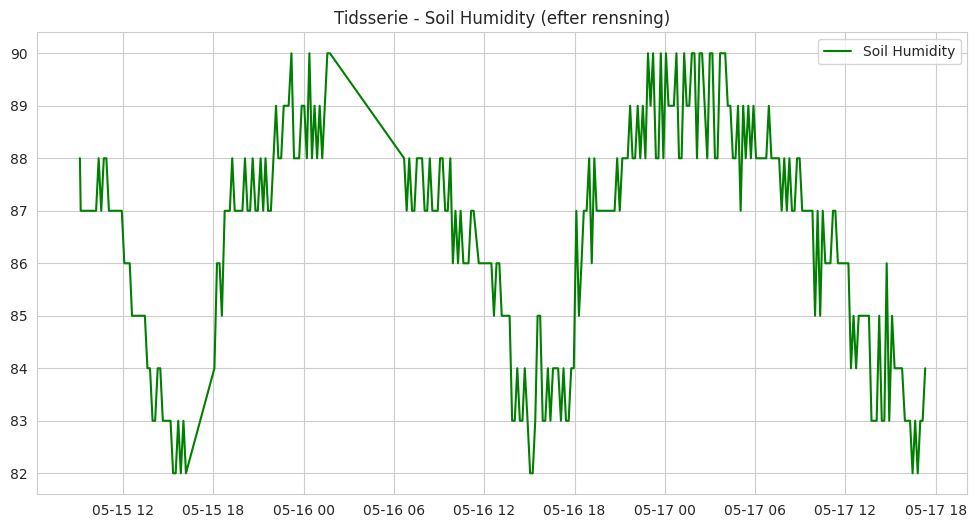

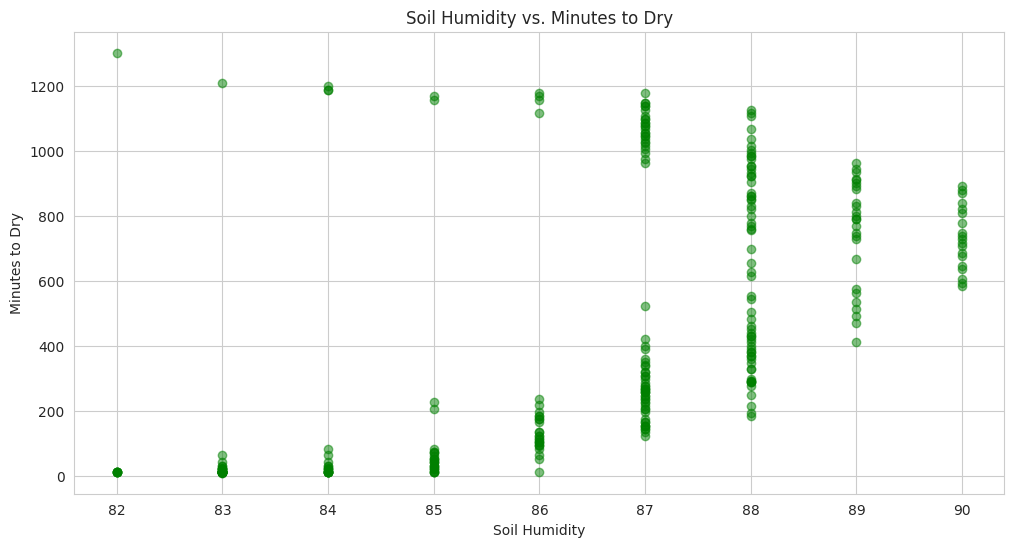

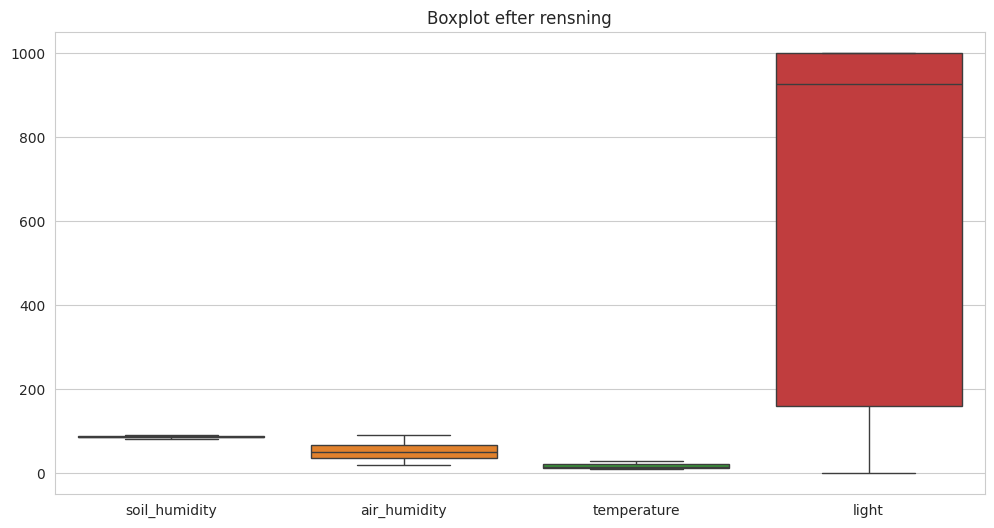

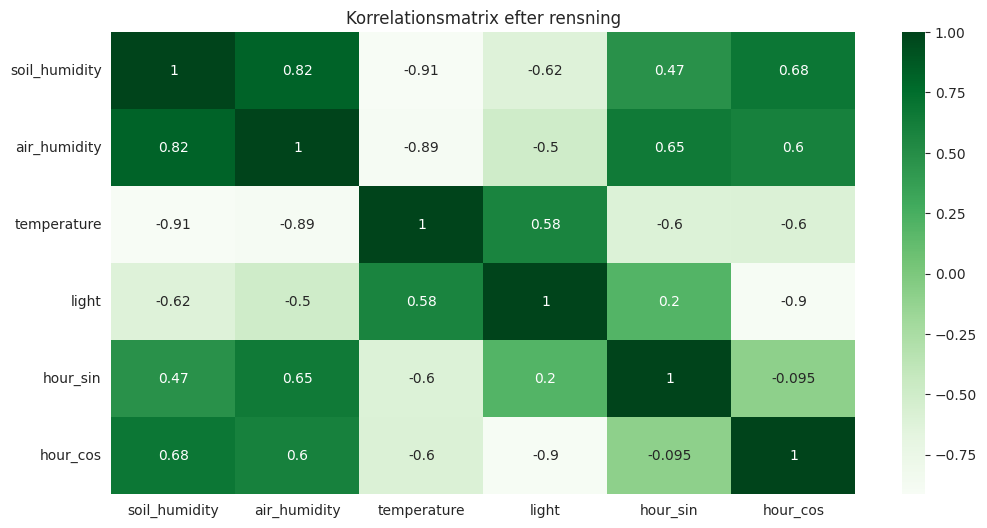

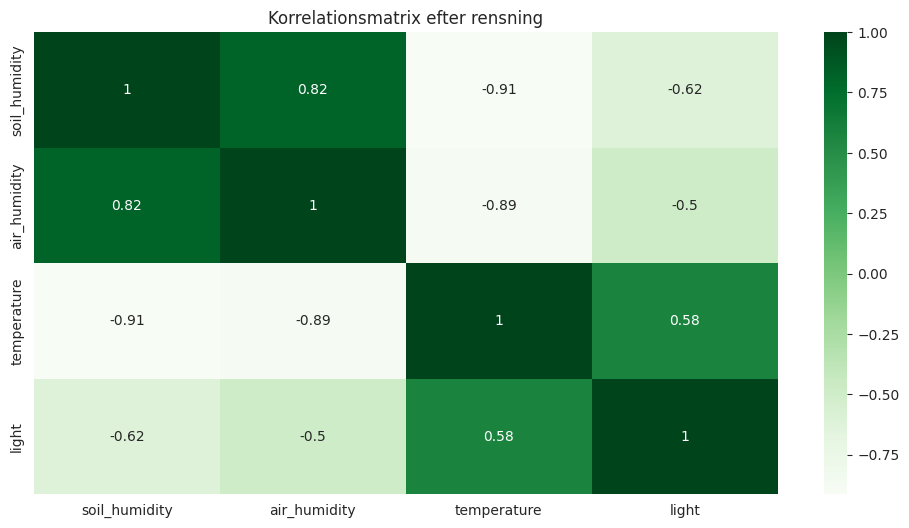

In [26]:
# --- Tidsserie og scatterplot ---
plt.plot(df_clean["timestamp"], df_clean["soil_humidity"], label="Soil Humidity", color="green")
plt.title("Tidsserie - Soil Humidity (efter rensning)")
plt.legend()
plt.savefig(f"{output_dir}/soil_humidity_timeseries_after_cleaning.png")
plt.show()

plt.scatter(df_clean["soil_humidity"], df_clean["minutes_to_dry"], alpha=0.5, color="green")
plt.title("Soil Humidity vs. Minutes to Dry")
plt.xlabel("Soil Humidity")
plt.ylabel("Minutes to Dry")
plt.savefig(f"{output_dir}/scatterplot_soilhumidity_vs_minutestodry.png")
plt.show()

# --- Boxplot efter rensning ---
sns.boxplot(data=df_clean[["soil_humidity", "air_humidity", "temperature", "light"]])
plt.title("Boxplot efter rensning")
plt.savefig(f"{output_dir}/boxplot_after_cleaning.png")
plt.show()

# heatmap efter rensning ---
sns.heatmap(df_clean[["soil_humidity", "air_humidity", "temperature", "light", "hour_sin", "hour_cos"]].corr(),
            annot=True, cmap='Greens')
plt.title("Korrelationsmatrix efter rensning")
plt.savefig(f"{output_dir}/correlation_matrix_after_cleaning.png")
plt.show()

# heatmap efter rensning #Keyvalues ---
sns.heatmap(df_clean[["soil_humidity", "air_humidity", "temperature", "light"]].corr(), annot=True, cmap='Greens')
plt.title("Korrelationsmatrix efter rensning")
plt.savefig(f"{output_dir}/correlation_matrix_after_cleaning_KV.png")
plt.show()


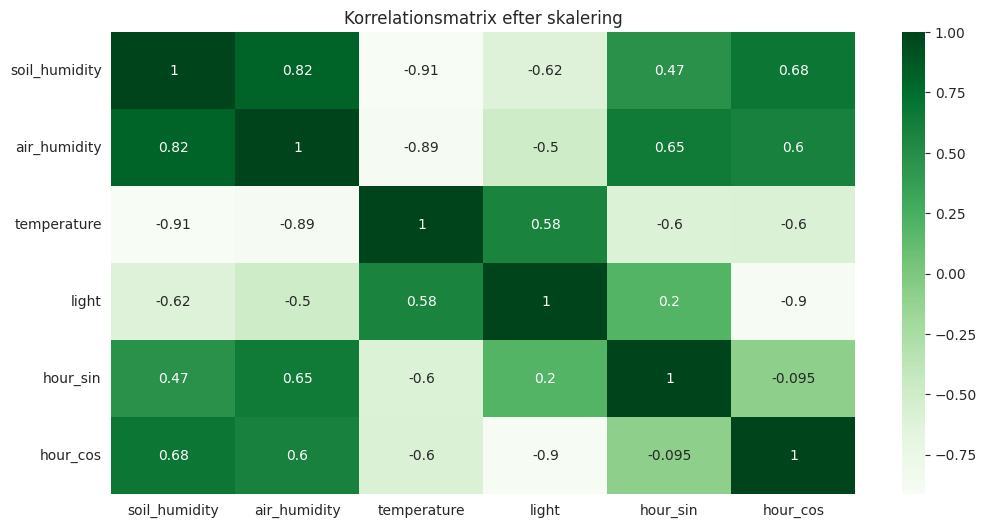

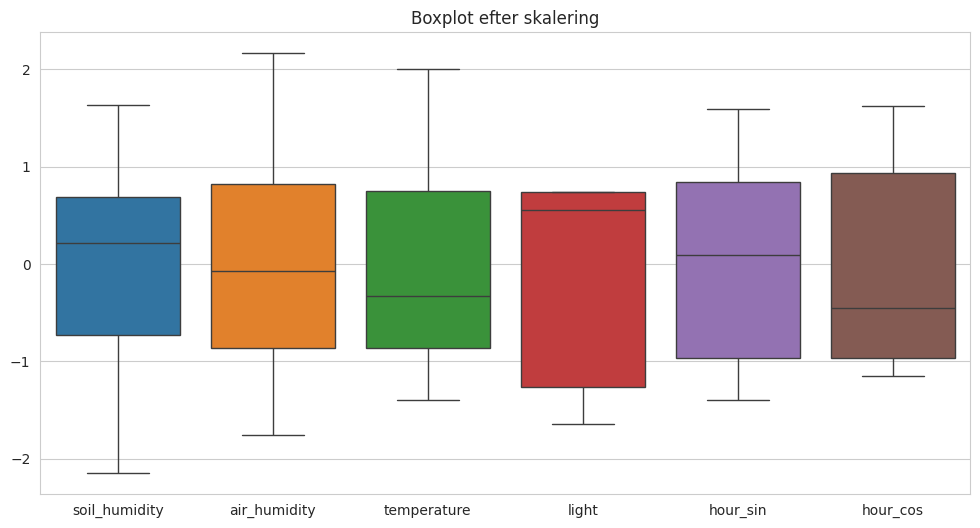

In [27]:
# --- Skalering ---
feature_cols = ["soil_humidity", "air_humidity", "temperature", "light", "hour_sin", "hour_cos"]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_clean[feature_cols])
df_scaled = pd.DataFrame(scaled_features, columns=feature_cols)

sns.heatmap(df_scaled.corr(), annot=True, cmap='Greens')
plt.title("Korrelationsmatrix efter skalering")
plt.savefig(f"{output_dir}/correlation_matrix_after_scaling.png")
plt.show()

sns.boxplot(data=df_scaled[feature_cols])
plt.title("Boxplot efter skalering")
plt.savefig(f"{output_dir}/boxplot_after_scaling.png")
plt.show()
